In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
r_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=r_cols, engine='python')
ratings.drop('timestamp', axis=1, inplace=True)

In [3]:
ratings['rating'] = (ratings['rating'] - np.mean(ratings['rating'])) / 4.0

In [4]:
def user_wise_train_test_split(ratings_df, test_size=0.2):
    train_list = []
    test_list = []

    for user_id, user_data in ratings_df.groupby('user_id'):
        if len(user_data) < 5: 
            train_list.append(user_data)
            continue
        train_data, test_data = train_test_split(
            user_data,
            test_size=test_size,
            random_state=None
        )
        train_list.append(train_data)
        test_list.append(test_data)

    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df

train_ratings, test_ratings = user_wise_train_test_split(ratings, test_size=0.2)
print(f"Train size: {len(train_ratings)}, Test size: {len(test_ratings)}")

Train size: 797758, Test size: 202451


In [5]:
# model = SVD_SGD_Recommender(num_factors=50, learning_rate=0.005, reg=0.02, epochs=50)
# model.fit(train_ratings, test_ratings)

# # ====================== Plot Metrics ======================
# model.plot_metrics()

In [16]:
class SVD_SGD_Recommender_1:
    def __init__(self, num_factors=50, learning_rate=0.005, reg=0.02, epochs=50):
        self.num_factors = num_factors
        self.lr = learning_rate
        self.reg = reg
        self.epochs = epochs
        self.U = None
        self.Sigma = None
        self.V = None
        self.train_loss_history = []
        self.train_mae_history = []
        self.train_rmse_history = []

        self.test_lost_history = []
        self.test_mae_history = []
        self.test_rmse_history = []
        self.user_mapping = None
        self.item_mapping = None

    def fit(self, train_ratings, test_ratings):
        # Ánh xạ user_id và item_id về index liên tục
        unique_users = train_ratings['user_id'].unique()
        unique_items = train_ratings['item_id'].unique()

        self.user_mapping = {uid: idx for idx, uid in enumerate(unique_users)}
        self.item_mapping = {iid: idx for idx, iid in enumerate(unique_items)}

        num_users = len(unique_users)
        num_items = len(unique_items)

        rating_matrix = np.zeros((num_users, num_items))

        for row in train_ratings.itertuples():
            user_idx = self.user_mapping[row.user_id]
            item_idx = self.item_mapping[row.item_id]
            rating_matrix[user_idx, item_idx] = row.rating

        # Khởi tạo SVD ban đầu
        U, S, Vt = np.linalg.svd(rating_matrix, full_matrices=False)
        self.U = U[:, :self.num_factors]
        self.V = Vt[:self.num_factors, :].T
        self.Sigma = np.diag(S[:self.num_factors])

        # SGD tối ưu hoá U, Sigma, V
        for epoch in range(self.epochs):
            total_loss = 0
            train_errors = 0
            for row in train_ratings.itertuples():
                user_idx = self.user_mapping[row.user_id]
                item_idx = self.item_mapping[row.item_id]
                true_rating = row.rating

                pred_rating = self.U[user_idx, :] @ self.Sigma @ self.V[item_idx, :].T
                error = true_rating - pred_rating

                # Tính gradient
                grad_U = -2 * error * (self.Sigma @ self.V[item_idx, :]) + self.reg * self.U[user_idx, :]
                grad_V = -2 * error * (self.Sigma.T @ self.U[user_idx, :]) + self.reg * self.V[item_idx, :]
                grad_S = -2 * error * np.outer(self.U[user_idx, :], self.V[item_idx, :]) + self.reg * self.Sigma

                # Cập nhật tham số
                self.U[user_idx, :] -= self.lr * grad_U
                self.V[item_idx, :] -= self.lr * grad_V
                self.Sigma -= self.lr * grad_S
                
                train_errors += np.abs(error)
                total_loss += error**2

            avg_loss = total_loss / len(train_ratings)
            train_rmse = np.sqrt(total_loss / len(train_ratings))
            train_mae = train_errors / len(train_ratings)
            test_loss, test_mae, test_rmse = self.evaluate(test_ratings)

            self.train_loss_history.append(avg_loss)
            self.train_mae_history.append(train_mae)
            self.train_rmse_history.append(train_rmse)

            self.test_lost_history.append(test_loss)
            self.test_mae_history.append(test_mae)
            self.test_rmse_history.append(test_rmse)

            print(f"Epoch {epoch+1}/{self.epochs} - Train Loss: {avg_loss:.4f} - Test Loss: {test_loss:.4f} \
                  | Train MAE: {train_mae:.4f} - Test MAE: {test_mae:.4f} \
                  | Train RMSE: {train_rmse:.4f} - Test RMSE: {test_rmse:.4f}")

    def predict(self, user_id, item_id):
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return None  # Tránh lỗi khi user hoặc item không tồn tại

        user_idx = self.user_mapping[user_id]
        item_idx = self.item_mapping[item_id]

        pred_norm = self.U[user_idx, :] @ self.Sigma @ self.V[item_idx, :].T
        # pred_denorm = self.scaler.inverse_transform([[pred_norm]])[0, 0]
        # return np.clip(pred_norm, 0, 5)
        return pred_norm

    def evaluate(self, test_data):
        errors = []
        squared_errors = []
        losses = []
        for row in test_data.itertuples():
            pred = self.predict(row.user_id, row.item_id)
            if pred is None:  # Bỏ qua nếu user hoặc item không tồn tại trong train
                continue

            # true = self.scaler.inverse_transform([[row.rating]])[0, 0]
            true = row.rating
            error = abs(true - pred)
            errors.append(error)
            squared_errors.append(error**2)
            losses.append(error**2)
        loss = np.mean(losses) if errors else np.nan
        mae = np.mean(errors) if errors else np.nan
        rmse = np.sqrt(np.mean(squared_errors)) if squared_errors else np.nan
        return loss, mae, rmse

    def plot_metrics(self):
        epochs = range(1, self.epochs + 1)
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_loss_history, label="Train Loss")
        plt.plot(epochs, self.test_lost_history, label="Test Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.train_mae_history, label="Train MAE")
        plt.plot(epochs, self.test_mae_history, label="Test MAE")
        plt.xlabel("Epochs")
        plt.ylabel("MAE")
        plt.title("MAE")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.train_rmse_history, label="Train RMSE")
        plt.plot(epochs, self.test_rmse_history, label="Test RMSE")
        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.title("RMSE")
        plt.legend()

        plt.tight_layout()
        plt.show()




Epoch 1/20 - Train Loss: 0.0752 - Test Loss: 0.0773                   | Train MAE: 0.2282 - Test MAE: 0.2325                   | Train RMSE: 0.2742 - Test RMSE: 0.2781
Epoch 2/20 - Train Loss: 0.0704 - Test Loss: 0.0662                   | Train MAE: 0.2204 - Test MAE: 0.2117                   | Train RMSE: 0.2653 - Test RMSE: 0.2573
Epoch 3/20 - Train Loss: 0.0627 - Test Loss: 0.0618                   | Train MAE: 0.2043 - Test MAE: 0.2021                   | Train RMSE: 0.2503 - Test RMSE: 0.2485
Epoch 4/20 - Train Loss: 0.0597 - Test Loss: 0.0600                   | Train MAE: 0.1979 - Test MAE: 0.1984                   | Train RMSE: 0.2444 - Test RMSE: 0.2450
Epoch 5/20 - Train Loss: 0.0579 - Test Loss: 0.0587                   | Train MAE: 0.1941 - Test MAE: 0.1958                   | Train RMSE: 0.2406 - Test RMSE: 0.2422
Epoch 6/20 - Train Loss: 0.0557 - Test Loss: 0.0564                   | Train MAE: 0.1897 - Test MAE: 0.1915                   | Train RMSE: 0.2361 - Test RMSE:

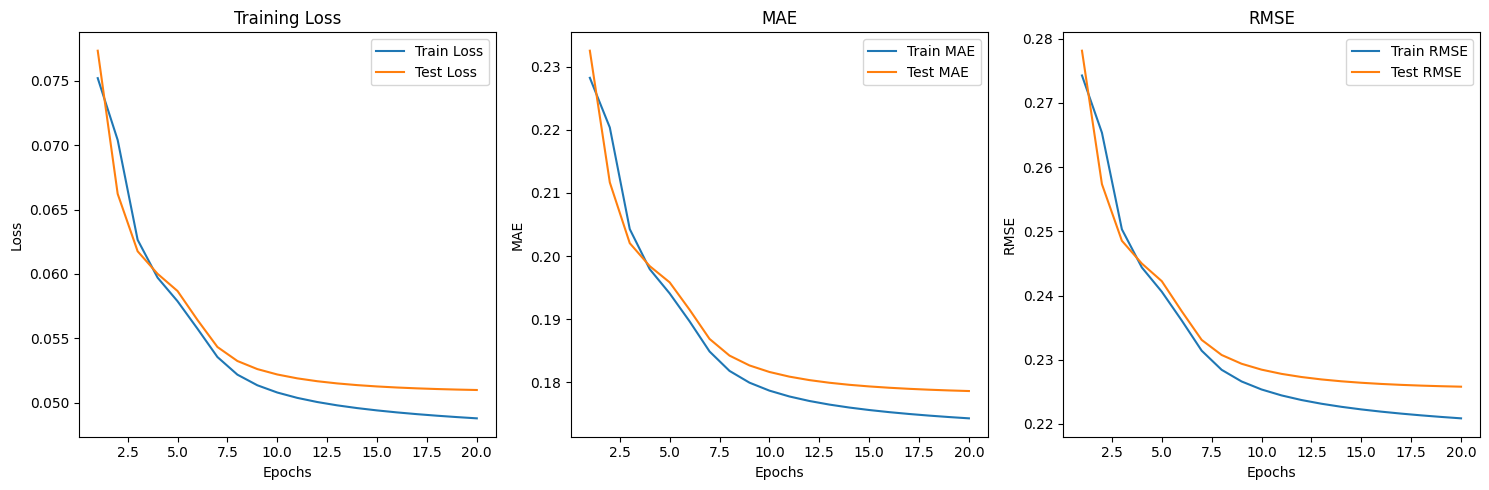

In [ ]:
# Huấn luyện mô hình
model = SVD_SGD_Recommender_1(num_factors=20, learning_rate=0.01, reg=0.005, epochs=20)
model.fit(train_ratings, test_ratings)

model.plot_metrics()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# class SVD_SGD_Recommender:
#     def __init__(self, num_factors=50, learning_rate=0.005, reg=0.02, epochs=50):
#         self.num_factors = num_factors
#         self.lr = learning_rate
#         self.reg = reg
#         self.epochs = epochs
#         self.U = None
#         self.Sigma = None
#         self.V = None
#         self.scaler = MinMaxScaler(feature_range=(0, 1))  # Chuẩn hóa về [0,1]
#         self.loss_history = []
#         self.train_mae_history = []
#         self.test_mae_history = []
#         self.rmse_history = []

#     def fit(self, train_ratings, test_ratings):
#         # Chuẩn hóa rating
#         # train_ratings[['rating']] = self.scaler.fit_transform(train_ratings[['rating']])
#         # test_ratings[['rating']] = self.scaler.transform(test_ratings[['rating']])
        
#         # Xây dựng ma trận rating
#         num_users = train_ratings['user_id'].nunique()
#         num_items = train_ratings['item_id'].nunique()
#         rating_matrix = np.zeros((num_users, num_items))

#         for row in train_ratings.itertuples():
#             rating_matrix[row.user_id - 1, row.item_id - 1] = row.rating

#         # Khởi tạo SVD ban đầu
#         U, S, Vt = np.linalg.svd(rating_matrix, full_matrices=False)
#         self.U = U[:, :self.num_factors]
#         self.V = Vt[:self.num_factors, :].T
#         self.Sigma = np.diag(S[:self.num_factors])

#         # SGD tối ưu hoá U, Sigma, V
#         for epoch in range(self.epochs):
#             total_loss = 0
#             train_errors = []

#             for row in train_ratings.itertuples():
#                 user_idx = row.user_id - 1
#                 item_idx = row.item_id - 1
#                 true_rating = row.rating

#                 pred_rating = self.U[user_idx, :] @ self.Sigma @ self.V[item_idx, :].T
#                 error = true_rating - pred_rating

#                 # Tính gradient
#                 grad_U = -2 * error * (self.Sigma @ self.V[item_idx, :]) + self.reg * self.U[user_idx, :]
#                 grad_V = -2 * error * (self.Sigma.T @ self.U[user_idx, :]) + self.reg * self.V[item_idx, :]
#                 grad_S = -2 * error * np.outer(self.U[user_idx, :], self.V[item_idx, :]) + self.reg * self.Sigma

#                 # Cập nhật tham số
#                 self.U[user_idx, :] -= self.lr * grad_U
#                 self.V[item_idx, :] -= self.lr * grad_V
#                 self.Sigma -= self.lr * grad_S

#                 total_loss += error**2
#                 train_errors.append(abs(error))

#             avg_loss = total_loss / len(train_ratings)
#             train_mae = np.mean(train_errors)
#             test_mae, test_rmse = self.evaluate(test_ratings)

#             self.loss_history.append(avg_loss)
#             self.train_mae_history.append(train_mae)
#             self.test_mae_history.append(test_mae)
#             self.rmse_history.append(test_rmse)

#             print(f"Epoch {epoch+1}/{self.epochs} - Loss: {avg_loss:.4f} | Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f}")

#     def predict(self, user_id, item_id):
#         user_idx = user_id - 1
#         item_idx = item_id - 1
#         pred_norm = self.U[user_idx, :] @ self.Sigma @ self.V[item_idx, :].T
#         pred_denorm = self.scaler.inverse_transform([[pred_norm]])[0, 0]  # Denormalize
#         return np.clip(pred_denorm, 0, 5)  # Giới hạn rating trong khoảng 0-5

#     def evaluate(self, test_data):
#         errors = []
#         squared_errors = []
#         for row in test_data.itertuples():
#             pred = self.predict(row.user_id, row.item_id)
#             true = self.scaler.inverse_transform([[row.rating]])[0, 0]  # Denormalize
#             error = abs(true - pred)
#             errors.append(error)
#             squared_errors.append(error**2)

#         mae = np.mean(errors)
#         rmse = np.sqrt(np.mean(squared_errors))
#         return mae, rmse

#     def plot_metrics(self):
#         epochs = range(1, self.epochs + 1)
#         plt.figure(figsize=(12, 5))

#         plt.subplot(1, 2, 1)
#         plt.plot(epochs, self.loss_history, label="Loss")
#         plt.xlabel("Epochs")
#         plt.ylabel("Loss")
#         plt.title("Training Loss")
#         plt.legend()

#         plt.subplot(1, 2, 2)
#         plt.plot(epochs, self.train_mae_history, label="Train MAE", marker="o")
#         plt.plot(epochs, self.test_mae_history, label="Test MAE", marker="s")
#         plt.plot(epochs, self.rmse_history, label="Test RMSE", marker="d")
#         plt.xlabel("Epochs")
#         plt.ylabel("Error")
#         plt.title("MAE & RMSE")
#         plt.legend()

#         plt.tight_layout()
#         plt.show()
